# 전체 Task를 모수로, 각 Task 별 Token Sequence(Prompt_text + Target_text) 의 길이 visualization

=== Analyzing Prompt vs Target Token Lengths (Includes SELFIES Tokens) ===
✅ Tokenizer loaded. Vocab size: 129325

Processing Train dataset (3440450 examples)...


Tokenizing Train (num_proc=64): 100%|██████████| 3440450/3440450 [00:34<00:00, 100418.24 examples/s]



Processing Val dataset (70515 examples)...


Tokenizing Val (num_proc=64): 100%|██████████| 70515/70515 [00:01<00:00, 65477.50 examples/s] 



Processing Test dataset (70515 examples)...


Tokenizing Test (num_proc=64): 100%|██████████| 70515/70515 [00:01<00:00, 48606.28 examples/s]



Calculating Detailed Statistics...

 [ Prompt Text Token Length Statistics ]
                                              Mean  Std  Min    5%   10%  Q1(25%)  Median  Q3(75%)   90%   95%  Max
Group                                  Split                                                                       
Description-Guided Molecule Generation Test  186.9 36.7  108 140.0 147.0    160.0   180.0    207.0 237.0 256.0  449
                                       Train 185.6 41.9  104 132.0 140.0    156.0   178.0    207.0 240.0 263.0  498
                                       Val   186.9 36.7  108 140.0 147.0    160.0   180.0    207.0 237.0 256.0  449
Forward Reaction Prediction            Test  176.5 33.2  119 139.0 144.0    155.0   169.0    189.0 214.0 236.4  407
                                       Train 175.8 33.2  114 138.0 144.0    154.0   169.0    189.0 214.0 237.0  487
                                       Val   176.5 33.2  119 139.0 144.0    155.0   169.0    189.0 214.0 236.4

/tmp/ipykernel_773499/399305030.py:247: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(
/tmp/ipykernel_773499/399305030.py:247: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(



Analysis plot saved to: Mol-LLM_Custom/utils/prompt_target_length_analysis.png


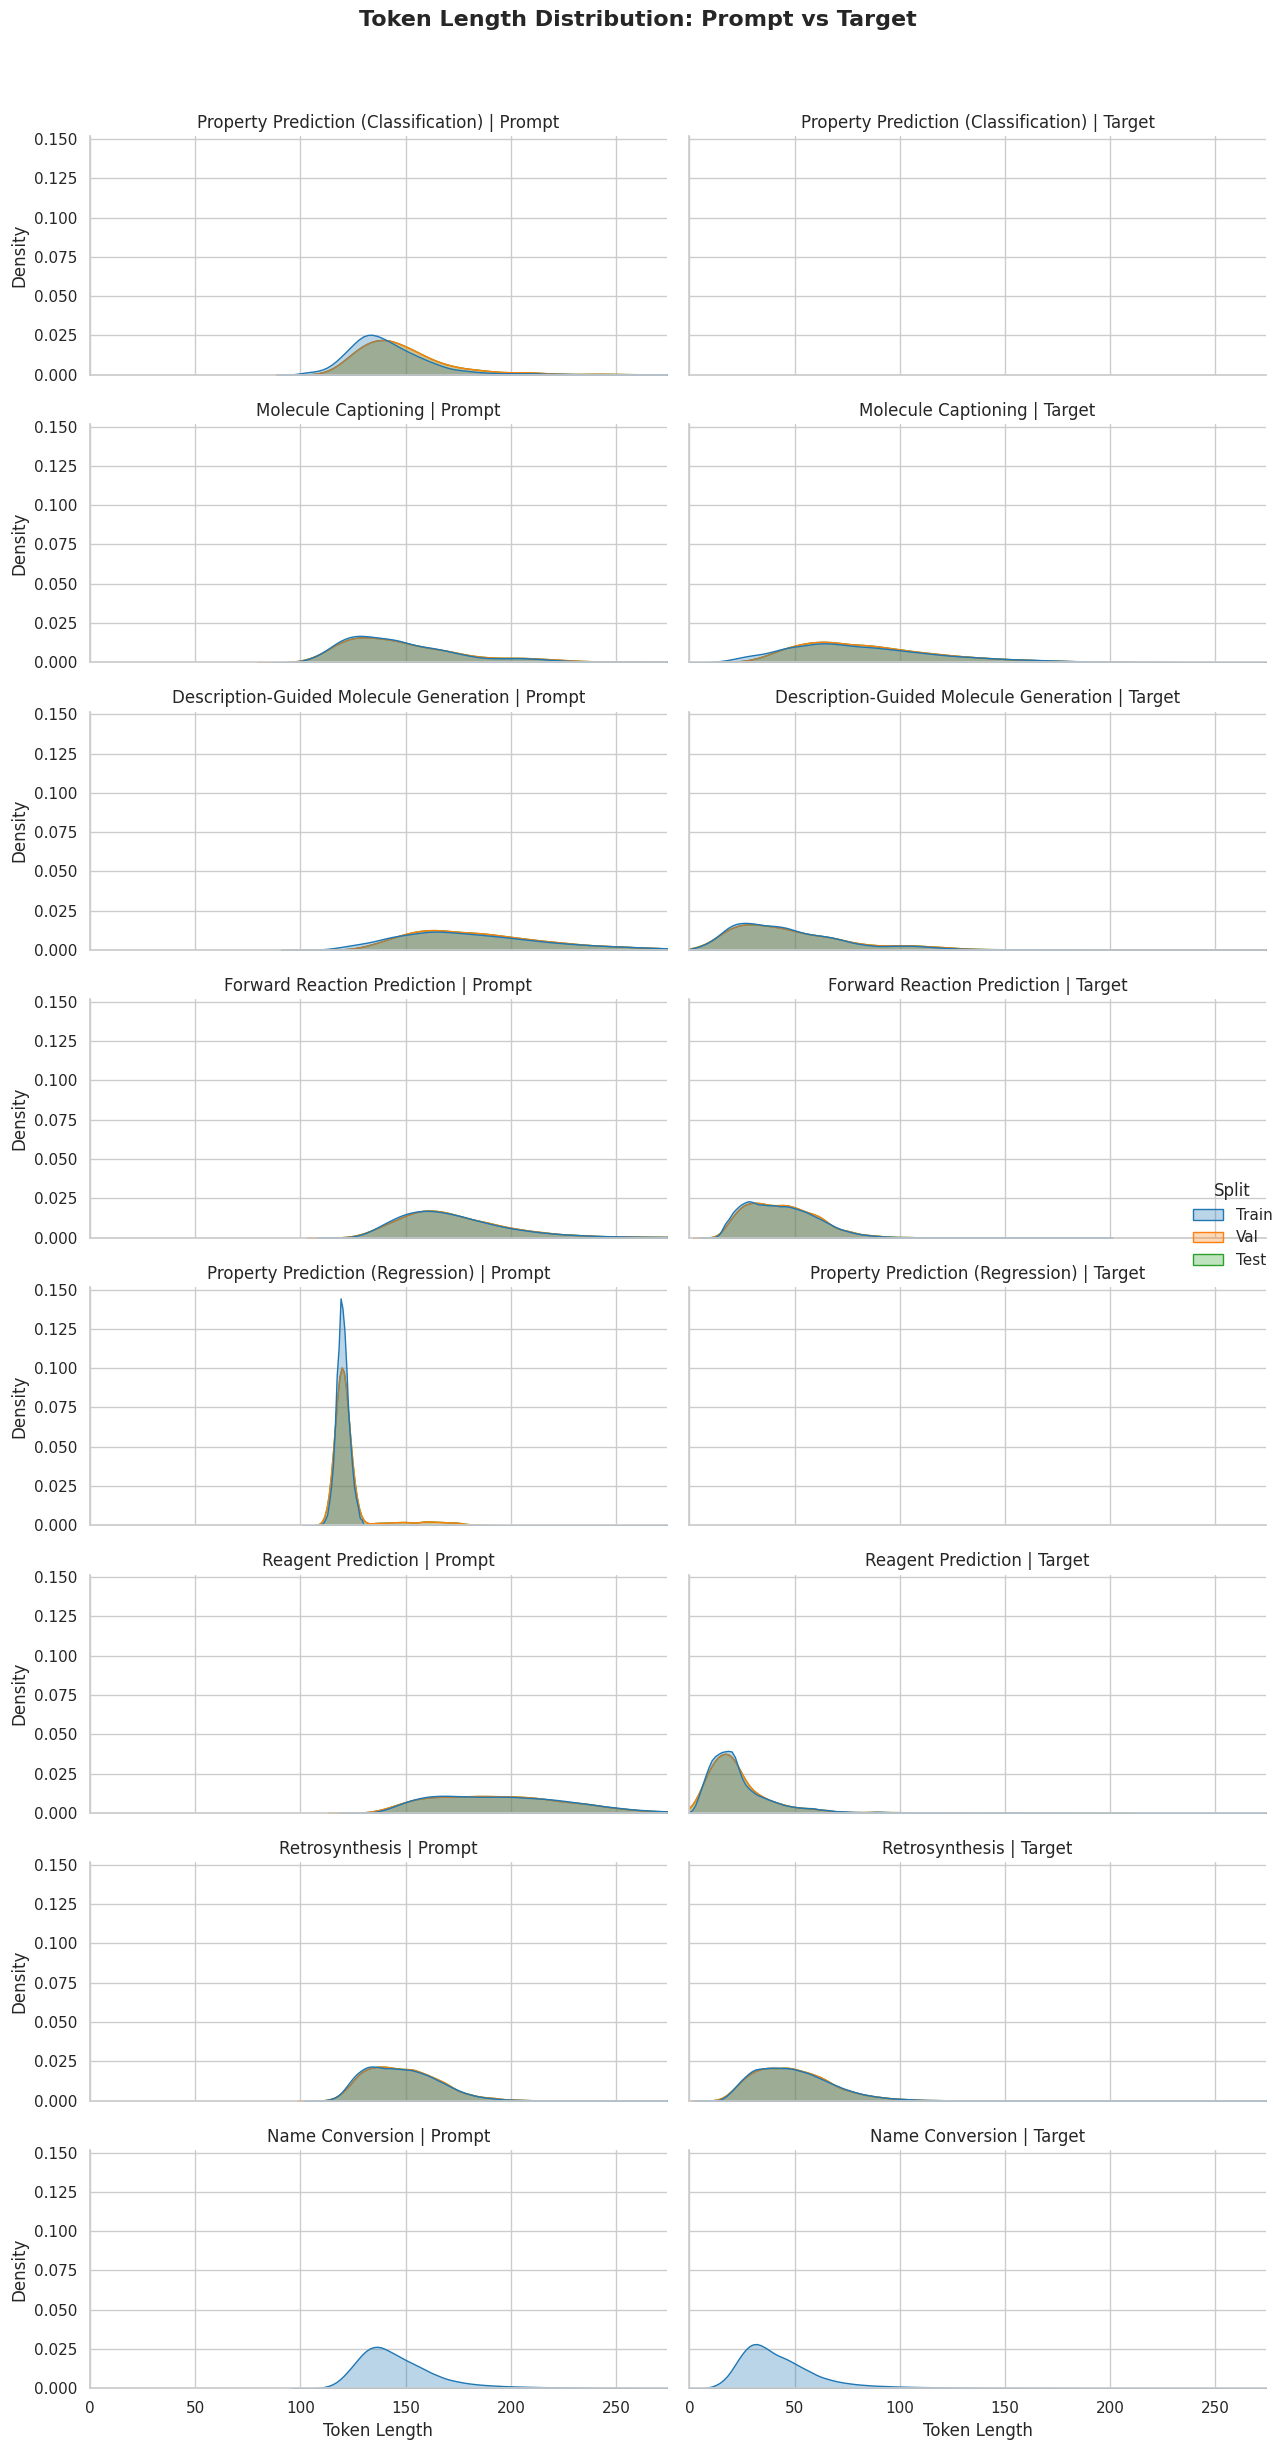

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
from transformers import AutoTokenizer
import multiprocessing as mp

# =============================================================================
# [설정] 변수 입력
# =============================================================================
MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct"
NUM_PROC = 64

# 데이터셋 경로
TRAIN_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415_verified_filtered_512"
VAL_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_validation_3.3M_0415_verified_filtered_512"
TEST_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415_verified_filtered_512"

# SELFIES 사전 경로
SELFIES_DICT_PATH = "Mol-LLM_Custom/model/selfies_dict.txt"

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# =============================================================================
# [1] Special Tokens 정의
# =============================================================================
BOOL = ["<BOOLEAN>", "</BOOLEAN>"]
FLOAT = ["<FLOAT>", "</FLOAT>"]
DESCRIPTION = ["<DESCRIPTION>", "</DESCRIPTION>"]
SELFIES = ["<SELFIES>", "</SELFIES>"]
MOL_2D = ["<GRAPH>", "</GRAPH>"]
MOL_3D = ["<3D_CONFORMER>", "</3D_CONFORMER>"]
MOL_EMBEDDING = ["<mol>"]
NUMBER = [f"<|{i}|>" for i in range(10)] + ["<|+|>", "<|-|>", "<|.|>"]
INSTRUCTION = ["<INSTRUCTION>", "</INSTRUCTION>"]
REACTION_DIRECTION = ["|>>|"]
IUPAC = ["<IUPAC>", "</IUPAC>"]
MOLFORMULA = ["<MOLFORMULA>", "</MOLFORMULA>"]

CUSTOM_SPECIAL_TOKENS = (
    BOOL + FLOAT + DESCRIPTION + SELFIES + MOL_2D + MOL_3D + 
    MOL_EMBEDDING + NUMBER + INSTRUCTION + REACTION_DIRECTION + 
    IUPAC + MOLFORMULA
)

global_tokenizer = None

def load_selfies_tokens(path):
    if not os.path.exists(path):
        print(f"[Warning] SELFIES dict not found at {path}")
        return []
    with open(path, 'r') as f:
        tokens = f.read().splitlines()
    return [t.strip() for t in tokens if t.strip()]

def init_worker():
    global global_tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        tokens_to_add = list(set(CUSTOM_SPECIAL_TOKENS))
        selfies_tokens = load_selfies_tokens(SELFIES_DICT_PATH)
        tokens_to_add.extend(selfies_tokens)
        
        existing_vocab = set(tokenizer.get_vocab().keys())
        final_tokens = [t for t in set(tokens_to_add) if t not in existing_vocab]
        
        if final_tokens:
            tokenizer.add_tokens(final_tokens)
            
        global_tokenizer = tokenizer
    except Exception as e:
        print(f"[Worker Error] Failed to load tokenizer: {e}")

# =============================================================================
# [Helper] Task Group Mapping
# =============================================================================
def get_task_group(task_name):
    if not isinstance(task_name, str): return "Others"
    t = task_name.lower()

    if "name_conversion" in t: return "Name Conversion"
    if "captioning" in t or "mol2text" in t: return "Molecule Captioning"
    if "generation" in t or "text2mol" in t: return "Description-Guided Molecule Generation"
    if "forward_reaction" in t or "forward_synthesis" in t: return "Forward Reaction Prediction"
    if "retrosynthesis" in t: return "Retrosynthesis"
    if "reagent" in t: return "Reagent Prediction"

    classification_keywords = ["tox21", "toxcast", "clintox", "bbbp", "bace", "sider", "hiv", "muv", "pcba", "multi_label_classification"]
    regression_keywords = ["esol", "freesolv", "lipo", "qm7", "qm8", "qm9", "u0", "cv", "mu", "alpha", "r2", "zpve", "gap", "homo", "lumo", "hopv"]

    if any(k in t for k in classification_keywords) or "classification" in t: return "Property Prediction (Classification)"
    if any(k in t for k in regression_keywords) or "regression" in t or "property" in t: return "Property Prediction (Regression)"

    return "Others"

# =============================================================================
# [Worker Function] Compute Length (Separated)
# =============================================================================
def compute_length_separate(batch):
    if global_tokenizer is None:
        init_worker()
        
    # Prompt와 Target을 각각 토큰화하여 길이 계산
    p_enc = global_tokenizer(batch['prompt_text'], add_special_tokens=True, truncation=False)
    t_enc = global_tokenizer(batch['target_text'], add_special_tokens=True, truncation=False)
    
    return {
        "prompt_length": [len(ids) for ids in p_enc['input_ids']],
        "target_length": [len(ids) for ids in t_enc['input_ids']]
    }

# =============================================================================
# [Stats] Custom Percentile Functions
# =============================================================================
# Pandas agg 함수에 전달하기 위한 헬퍼 함수들
def p05(x): return x.quantile(0.05)
def p10(x): return x.quantile(0.10)
def p25(x): return x.quantile(0.25) # Q1
def p75(x): return x.quantile(0.75) # Q3
def p90(x): return x.quantile(0.90)
def p95(x): return x.quantile(0.95)

def main():
    print(f"=== Analyzing Prompt vs Target Token Lengths (Includes SELFIES Tokens) ===")
    
    # 1. 토크나이저 테스트
    init_worker()
    if global_tokenizer:
        print(f"✅ Tokenizer loaded. Vocab size: {len(global_tokenizer)}")
    else:
        return

    # 2. 데이터셋 로드
    datasets_dict = {}
    if os.path.exists(TRAIN_PATH): datasets_dict['Train'] = load_from_disk(TRAIN_PATH)
    if os.path.exists(VAL_PATH): datasets_dict['Val'] = load_from_disk(VAL_PATH)
    if os.path.exists(TEST_PATH): datasets_dict['Test'] = load_from_disk(TEST_PATH)

    if not datasets_dict:
        print("No datasets found.")
        return

    # 3. 길이 계산
    all_data_list = []
    for split_name in ['Train', 'Val', 'Test']:  # Train, Val, Test 순서로 진행을 강제
        if split_name not in datasets_dict:
            continue
        ds = datasets_dict[split_name]
        print(f"\nProcessing {split_name} dataset ({len(ds)} examples)...")
        if 'task' not in ds.column_names: continue

        ds_with_len = ds.map(
            compute_length_separate,
            batched=True,
            num_proc=NUM_PROC,
            desc=f"Tokenizing {split_name}",
            load_from_cache_file=False 
        )
        
        # 필요한 컬럼만 추출
        df_temp = ds_with_len.select_columns(['prompt_length', 'target_length', 'task']).to_pandas()
        df_temp['Split'] = split_name
        df_temp['Group'] = df_temp['task'].apply(get_task_group)
        all_data_list.append(df_temp)

    if not all_data_list: return
    full_df = pd.concat(all_data_list, ignore_index=True)

    # =============================================================================
    # 4. 통계 분석 (Statistics)
    # =============================================================================
    print("\nCalculating Detailed Statistics...")

    # 집계할 메트릭 정의
    stats_metrics = [
        'mean', 'std', 'min', 
        p05, p10, p25, 'median', p75, p90, p95, 
        'max'
    ]
    
    # 컬럼명 매핑 (보기 좋게)
    metric_names = {
        'mean': 'Mean', 'std': 'Std', 'min': 'Min', 
        'p05': '5%', 'p10': '10%', 'p25': 'Q1(25%)', 'median': 'Median', 
        'p75': 'Q3(75%)', 'p90': '90%', 'p95': '95%', 'max': 'Max'
    }

    # GroupBy Aggregation
    # Prompt와 Target 각각에 대해 통계 산출
    summary_df = full_df.groupby(['Group', 'Split'])[['prompt_length', 'target_length']].agg(stats_metrics)
    
    # 컬럼 이름 정리
    summary_df = summary_df.rename(columns=metric_names)
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.float_format', '{:.1f}'.format)

    print("\n" + "="*120)
    print(" [ Prompt Text Token Length Statistics ]")
    print("="*120)
    print(summary_df['prompt_length'].to_string())
    
    print("\n" + "="*120)
    print(" [ Target Text Token Length Statistics ]")
    print("="*120)
    print(summary_df['target_length'].to_string())

    # =============================================================================
    # 5. 시각화 (Visualization)
    # =============================================================================
    print("\nGenerating Distributions Plots...")
    
    # 시각화를 위해 데이터를 Melt 시킴 (Prompt/Target 구분을 위해)
    melted_df = full_df.melt(
        id_vars=['Group', 'Split'], 
        value_vars=['prompt_length', 'target_length'],
        var_name='Text_Type', 
        value_name='Token_Length'
    )
    
    # Prompt_Length -> Prompt, Target_Length -> Target 으로 이름 변경
    melted_df['Text_Type'] = melted_df['Text_Type'].replace({
        'prompt_length': 'Prompt', 
        'target_length': 'Target'
    })

    # Split 순서를 Train, Val, Test로 강제 설정
    melted_df['Split'] = pd.Categorical(
        melted_df['Split'], 
        categories=['Train', 'Val', 'Test'], 
        ordered=True
    )

    sns.set_theme(style="whitegrid")
    
    # FacetGrid 생성 (행: Group, 열: Text_Type, 색상: Split)
    # x축 limit은 데이터의 99% 지점 정도로 자르는 것이 시각적으로 좋습니다 (Outlier 제외)
    upper_limit = full_df[['prompt_length', 'target_length']].quantile(0.99).max()
    
    g = sns.displot(
        data=melted_df,
        x="Token_Length",
        hue="Split",
        col="Text_Type",
        row="Group",
        kind="kde",      # 히스토그램 대신 KDE 곡선 사용 (분포 비교 용이)
        fill=True,       # 내부 채우기
        height=3,
        aspect=2,
        palette={'Train': '#1f77b4', 'Val': '#ff7f0e', 'Test': '#2ca02c'},
        alpha=0.3,
        common_norm=False # 각 그룹별로 normalize
    )
    
    g.set(xlim=(0, upper_limit)) # 너무 긴 꼬리 자르기
    g.set_titles("{row_name} | {col_name}")
    g.set_axis_labels("Token Length", "Density")
    g.fig.suptitle(f"Token Length Distribution: Prompt vs Target", y=1.02, fontsize=16, fontweight='bold')

    plt.tight_layout()
    save_path = "prompt_target_length_analysis.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nAnalysis plot saved to: {os.path.abspath(save_path)}")

main()

In [1]:
import os
import pandas as pd
from datasets import load_from_disk
from transformers import AutoTokenizer

# =============================================================================
# [설정] 경로 및 변수
# =============================================================================
MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct"
NUM_PROC = 64
MAX_LENGTH = 512

# 입력 경로 (Step 1에서 생성된 최종 클린 데이터셋)
INPUT_PATHS = {
    "train": "Mol-LLM_Custom/dataset/train_official/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_FINAL_CLEANED",
    "val": "Mol-LLM_Custom/dataset/train_official/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_val_FINAL_CLEANED",
    "test": "Mol-LLM_Custom/dataset/train_official/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_FINAL_CLEANED"
}

# 출력 디렉토리
SAVE_DIR = "Mol-LLM_Custom/dataset/train_official/"

# SELFIES 사전 경로
SELFIES_DICT_PATH = "Mol-LLM_Custom/model/selfies_dict.txt"

# =============================================================================
# [1] 토크나이저 준비 (Special Tokens 포함)
# =============================================================================
def get_custom_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
    
    # 기본 스페셜 토큰 정의 (이전 코드와 동일)
    CUSTOM_SPECIAL_TOKENS = [
        "<BOOLEAN>", "</BOOLEAN>", "<FLOAT>", "</FLOAT>", "<DESCRIPTION>", "</DESCRIPTION>",
        "<SELFIES>", "</SELFIES>", "<GRAPH>", "</GRAPH>", "<3D_CONFORMER>", "</3D_CONFORMER>",
        "<mol>", "<|0|>", "<|1|>", "<|2|>", "<|3|>", "<|4|>", "<|5|>", "<|6|>", "<|7|>", 
        "<|8|>", "<|9|>", "<|+|>", "<|-|>", "<|.|>", "<INSTRUCTION>", "</INSTRUCTION>", 
        "|>>|", "<IUPAC>", "</IUPAC>", "<MOLFORMULA>", "</MOLFORMULA>"
    ]
    
    if os.path.exists(SELFIES_DICT_PATH):
        with open(SELFIES_DICT_PATH, 'r') as f:
            selfies_tokens = [line.strip() for line in f if line.strip()]
        CUSTOM_SPECIAL_TOKENS.extend(selfies_tokens)
    
    tokenizer.add_tokens(list(set(CUSTOM_SPECIAL_TOKENS)))
    return tokenizer

tokenizer = get_custom_tokenizer()

# =============================================================================
# [2] 필터링 함수 정의
# =============================================================================
def filter_by_length(batch):
    # Prompt와 Target을 토큰화 (전체 길이를 측정하기 위해 truncation=False)
    p_enc = tokenizer(batch['prompt_text'], add_special_tokens=False)
    t_enc = tokenizer(batch['target_text'], add_special_tokens=False)
    
    # 결과 리스트 (각 샘플별로 합산 길이가 512 이하인 것만 True)
    keep_indices = []
    for p_ids, t_ids in zip(p_enc['input_ids'], t_enc['input_ids']):
        # Prompt + Target 길이가 512 이내인지 확인
        if len(p_ids) + len(t_ids) <= MAX_LENGTH:
            keep_indices.append(True)
        else:
            keep_indices.append(False)
    return keep_indices

# =============================================================================
# [3] 메인 실행 루프
# =============================================================================
def run_truncation_pipeline():
    for split, path in INPUT_PATHS.items():
        if not os.path.exists(path):
            print(f"[Skip] {split} dataset not found at {path}")
            continue
            
        print(f"\n>>> Processing {split.upper()} Split...")
        ds = load_from_disk(path)
        original_count = len(ds)
        
        # 필터링 수행
        # .filter()의 batched=True를 사용하여 토큰화 속도를 높입니다.
        ds_filtered = ds.filter(
            filter_by_length,
            batched=True,
            batch_size=1000,
            num_proc=NUM_PROC,
            desc=f"Filtering {split} (> {MAX_LENGTH} tokens)"
        )
        
        filtered_count = len(ds_filtered)
        dropped_count = original_count - filtered_count
        
        print(f" - Original: {original_count:,}")
        print(f" - Filtered: {filtered_count:,}")
        print(f" - Dropped:  {dropped_count:,} ({ (dropped_count/original_count)*100:.2f}%)")
        
        # 저장 경로 생성
        # 예: GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_512_Truncation
        save_name = f"GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_{split}_512_Truncation"
        save_full_path = os.path.join(SAVE_DIR, save_name)
        
        ds_filtered.save_to_disk(save_full_path)
        print(f"[Success] Saved to: {save_full_path}")

if __name__ == "__main__":
    run_truncation_pipeline()

/home/jovyan/miniconda3/envs/MolDA_CHJ/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]



>>> Processing TRAIN Split...


Loading dataset from disk:   0%|          | 0/44 [00:00<?, ?it/s]

Filtering train (> 512 tokens) (num_proc=64):   0%|          | 0/3313489 [00:00<?, ? examples/s]

 - Original: 3,313,489
 - Filtered: 3,303,537
 - Dropped:  9,952 (0.30%)


Saving the dataset (0/43 shards):   0%|          | 0/3303537 [00:00<?, ? examples/s]

[Success] Saved to: Mol-LLM_Custom/dataset/train_official/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_512_Truncation

>>> Processing VAL Split...


Filtering val (> 512 tokens) (num_proc=64):   0%|          | 0/35199 [00:00<?, ? examples/s]

 - Original: 35,199
 - Filtered: 35,042
 - Dropped:  157 (0.45%)


Saving the dataset (0/1 shards):   0%|          | 0/35042 [00:00<?, ? examples/s]

[Success] Saved to: Mol-LLM_Custom/dataset/train_official/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_val_512_Truncation

>>> Processing TEST Split...


Filtering test (> 512 tokens) (num_proc=64):   0%|          | 0/32822 [00:00<?, ? examples/s]

 - Original: 32,822
 - Filtered: 32,595
 - Dropped:  227 (0.69%)


Saving the dataset (0/1 shards):   0%|          | 0/32595 [00:00<?, ? examples/s]

[Success] Saved to: Mol-LLM_Custom/dataset/train_official/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_512_Truncation


# Property Prediction (Classification)를 제외한 통계 기본

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
from transformers import AutoTokenizer
import multiprocessing as mp

# =============================================================================
# [설정] 변수 입력
# =============================================================================
MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct"
NUM_PROC = 64

# 데이터셋 경로
TRAIN_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415_verified_filtered_512"
VAL_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_validation_3.3M_0415_verified_filtered_512"
TEST_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415_verified_filtered_512"

# SELFIES 사전 경로
SELFIES_DICT_PATH = "Mol-LLM_Custom/model/selfies_dict.txt"

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# =============================================================================
# [1] Special Tokens 정의
# =============================================================================
BOOL = ["<BOOLEAN>", "</BOOLEAN>"]
FLOAT = ["<FLOAT>", "</FLOAT>"]
DESCRIPTION = ["<DESCRIPTION>", "</DESCRIPTION>"]
SELFIES = ["<SELFIES>", "</SELFIES>"]
MOL_2D = ["<GRAPH>", "</GRAPH>"]
MOL_3D = ["<3D_CONFORMER>", "</3D_CONFORMER>"]
MOL_EMBEDDING = ["<mol>"]
NUMBER = [f"<|{i}|>" for i in range(10)] + ["<|+|>", "<|-|>", "<|.|>"]
INSTRUCTION = ["<INSTRUCTION>", "</INSTRUCTION>"]
REACTION_DIRECTION = ["|>>|"]
IUPAC = ["<IUPAC>", "</IUPAC>"]
MOLFORMULA = ["<MOLFORMULA>", "</MOLFORMULA>"]

CUSTOM_SPECIAL_TOKENS = (
    BOOL + FLOAT + DESCRIPTION + SELFIES + MOL_2D + MOL_3D + 
    MOL_EMBEDDING + NUMBER + INSTRUCTION + REACTION_DIRECTION + 
    IUPAC + MOLFORMULA
)

global_tokenizer = None

def load_selfies_tokens(path):
    if not os.path.exists(path):
        print(f"[Warning] SELFIES dict not found at {path}")
        return []
    with open(path, 'r') as f:
        tokens = f.read().splitlines()
    return [t.strip() for t in tokens if t.strip()]

def init_worker():
    global global_tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        tokens_to_add = list(set(CUSTOM_SPECIAL_TOKENS))
        selfies_tokens = load_selfies_tokens(SELFIES_DICT_PATH)
        tokens_to_add.extend(selfies_tokens)
        
        existing_vocab = set(tokenizer.get_vocab().keys())
        final_tokens = [t for t in set(tokens_to_add) if t not in existing_vocab]
        
        if final_tokens:
            tokenizer.add_tokens(final_tokens)
            
        global_tokenizer = tokenizer
    except Exception as e:
        print(f"[Worker Error] Failed to load tokenizer: {e}")

# =============================================================================
# [Helper] Task Group Mapping
# =============================================================================
def get_task_group(task_name):
    if not isinstance(task_name, str): return "Others"
    t = task_name.lower()

    if "name_conversion" in t: return "Name Conversion"
    if "captioning" in t or "mol2text" in t: return "Molecule Captioning"
    if "generation" in t or "text2mol" in t: return "Description-Guided Molecule Generation"
    if "forward_reaction" in t or "forward_synthesis" in t: return "Forward Reaction Prediction"
    if "retrosynthesis" in t: return "Retrosynthesis"
    if "reagent" in t: return "Reagent Prediction"

    classification_keywords = ["tox21", "toxcast", "clintox", "bbbp", "bace", "sider", "hiv", "muv", "pcba", "multi_label_classification"]
    regression_keywords = ["esol", "freesolv", "lipo", "qm7", "qm8", "qm9", "u0", "cv", "mu", "alpha", "r2", "zpve", "gap", "homo", "lumo", "hopv"]

    if any(k in t for k in classification_keywords) or "classification" in t: return "Property Prediction (Classification)"
    if any(k in t for k in regression_keywords) or "regression" in t or "property" in t: return "Property Prediction (Regression)"

    return "Others"

# =============================================================================
# [Worker Function] Compute Length (Separated)
# =============================================================================
def compute_length_separate(batch):
    if global_tokenizer is None:
        init_worker()
        
    # Prompt와 Target을 각각 토큰화하여 길이 계산
    p_enc = global_tokenizer(batch['prompt_text'], add_special_tokens=True, truncation=False)
    t_enc = global_tokenizer(batch['target_text'], add_special_tokens=True, truncation=False)
    
    return {
        "prompt_length": [len(ids) for ids in p_enc['input_ids']],
        "target_length": [len(ids) for ids in t_enc['input_ids']]
    }

# =============================================================================
# [Stats] Custom Percentile Functions
# =============================================================================
def p05(x): return x.quantile(0.05)
def p10(x): return x.quantile(0.10)
def p25(x): return x.quantile(0.25)
def p75(x): return x.quantile(0.75)
def p90(x): return x.quantile(0.90)
def p95(x): return x.quantile(0.95)

def main():
    print(f"=== Analyzing Prompt vs Target Token Lengths (Aggregated, excluding Classification) ===")
    
    # 1. 토크나이저 테스트
    init_worker()
    if global_tokenizer:
        print(f"✅ Tokenizer loaded. Vocab size: {len(global_tokenizer)}")
    else:
        return

    # 2. 데이터셋 로드
    datasets_dict = {}
    if os.path.exists(TRAIN_PATH): datasets_dict['Train'] = load_from_disk(TRAIN_PATH)
    if os.path.exists(VAL_PATH): datasets_dict['Val'] = load_from_disk(VAL_PATH)
    if os.path.exists(TEST_PATH): datasets_dict['Test'] = load_from_disk(TEST_PATH)

    if not datasets_dict:
        print("No datasets found.")
        return

    # 3. 길이 계산
    all_data_list = []
    for split_name in ['Train', 'Val', 'Test']:
        if split_name not in datasets_dict:
            continue
        ds = datasets_dict[split_name]
        print(f"\nProcessing {split_name} dataset ({len(ds)} examples)...")
        if 'task' not in ds.column_names: continue

        ds_with_len = ds.map(
            compute_length_separate,
            batched=True,
            num_proc=NUM_PROC,
            desc=f"Tokenizing {split_name}",
            load_from_cache_file=False 
        )
        
        df_temp = ds_with_len.select_columns(['prompt_length', 'target_length', 'task']).to_pandas()
        df_temp['Split'] = split_name
        df_temp['Group'] = df_temp['task'].apply(get_task_group)
        all_data_list.append(df_temp)

    if not all_data_list: return
    full_df = pd.concat(all_data_list, ignore_index=True)

    # =============================================================================
    # 4. 필터링 및 데이터 가공
    # =============================================================================
    print("\nFiltering Data...")
    
    # [핵심] Property Prediction (Classification) 태스크 제외
    exclude_group = "Property Prediction (Classification)"
    filtered_df = full_df[full_df['Group'] != exclude_group].copy()
    
    print(f"Total samples: {len(full_df)}")
    print(f"Filtered samples (excluding {exclude_group}): {len(filtered_df)}")
    print(f"Excluded count: {len(full_df) - len(filtered_df)}")

    # 시각화를 위해 Melt
    melted_df = filtered_df.melt(
        id_vars=['Group', 'Split'], 
        value_vars=['prompt_length', 'target_length'],
        var_name='Text_Type', 
        value_name='Token_Length'
    )
    
    melted_df['Text_Type'] = melted_df['Text_Type'].replace({
        'prompt_length': 'Prompt', 
        'target_length': 'Target'
    })

    # Split 순서 강제
    melted_df['Split'] = pd.Categorical(
        melted_df['Split'], 
        categories=['Train', 'Val', 'Test'], 
        ordered=True
    )

    # =============================================================================
    # 5. 통계 분석 (Statistics) - 필터링된 데이터 기준
    # =============================================================================
    print("\nCalculating Statistics for Filtered Data...")
    
    stats_metrics = [
        'mean', 'std', 'min', 
        p05, p10, p25, 'median', p75, p90, p95, 
        'max'
    ]
    metric_names = {
        'mean': 'Mean', 'std': 'Std', 'min': 'Min', 
        'p05': '5%', 'p10': '10%', 'p25': 'Q1(25%)', 'median': 'Median', 
        'p75': 'Q3(75%)', 'p90': '90%', 'p95': '95%', 'max': 'Max'
    }

    # 전체 합쳐서(All Groups Combined) 통계 산출 (Split별)
    # GroupBy에서 'Group'을 제외하고 'Split'으로만 묶음
    summary_df = filtered_df.groupby(['Split'])[['prompt_length', 'target_length']].agg(stats_metrics)
    summary_df = summary_df.rename(columns=metric_names)
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.float_format', '{:.1f}'.format)

    print("\n" + "="*120)
    print(f" [ Aggregated Statistics (Excluding {exclude_group}) ]")
    print("="*120)
    print(summary_df.to_string())

    # =============================================================================
    # 6. 시각화 (Visualization) - Histogram
    # =============================================================================
    print("\nGenerating Aggregated Histogram...")
    
    sns.set_theme(style="whitegrid")
    
    # x축 Limit 설정을 위한 Quantile 계산
    upper_limit = filtered_df[['prompt_length', 'target_length']].quantile(0.99).max()
    
    # [수정] row="Group"을 제거하여 모든 그룹을 하나로 합침
    g = sns.displot(
        data=melted_df,
        x="Token_Length",
        hue="Split",        # Train/Val/Test 색상 구분
        col="Text_Type",    # Prompt / Target 열 구분
        kind="hist",        # 히스토그램 (kde 곡선 포함 가능)
        kde=True,           # 분포 곡선 추가
        element="step",     # 계단형 히스토그램
        stat="count",       # y축은 갯수
        common_norm=False,  # 각 Split별로 normalize 하지 않고 실제 카운트(또는 density) 유지
        height=5,
        aspect=1.5,
        palette={'Train': '#1f77b4', 'Val': '#ff7f0e', 'Test': '#2ca02c'},
        alpha=0.3
    )
    
    g.set(xlim=(0, upper_limit))
    g.set_titles("{col_name}")
    g.set_axis_labels("Token Length", "Count")
    
    title_str = f"Token Length Histogram (Aggregated)\nExcluded: {exclude_group}"
    g.fig.suptitle(title_str, y=1.05, fontsize=16, fontweight='bold')

    plt.tight_layout()
    save_path = "aggregated_histogram_wo_classification.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nAnalysis plot saved to: {os.path.abspath(save_path)}")

if __name__ == "__main__":
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass
    main()

/home/jovyan/miniconda3/envs/MolDA_CHJ/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

# 각 그룹별 Token 길이 기본 통계

In [2]:
import os
import pandas as pd
import numpy as np
from datasets import load_from_disk
from transformers import AutoTokenizer
import multiprocessing as mp

# =============================================================================
# [설정] 변수 입력
# =============================================================================
MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct"
NUM_PROC = 64

# 데이터셋 경로 (사용자 환경에 맞게 수정됨)
TRAIN_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415_verified_filtered_512"
VAL_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_validation_3.3M_0415_verified_filtered_512"
TEST_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415_verified_filtered_512"

# SELFIES 사전 경로
SELFIES_DICT_PATH = "Mol-LLM_Custom/model/selfies_dict.txt"

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# =============================================================================
# [1] Special Tokens & Tokenizer Setup
# =============================================================================
# ... (기존과 동일한 토큰 정의) ...
BOOL = ["<BOOLEAN>", "</BOOLEAN>"]
FLOAT = ["<FLOAT>", "</FLOAT>"]
DESCRIPTION = ["<DESCRIPTION>", "</DESCRIPTION>"]
SELFIES = ["<SELFIES>", "</SELFIES>"]
MOL_2D = ["<GRAPH>", "</GRAPH>"]
MOL_3D = ["<3D_CONFORMER>", "</3D_CONFORMER>"]
MOL_EMBEDDING = ["<mol>"]
NUMBER = [f"<|{i}|>" for i in range(10)] + ["<|+|>", "<|-|>", "<|.|>"]
INSTRUCTION = ["<INSTRUCTION>", "</INSTRUCTION>"]
REACTION_DIRECTION = ["|>>|"]
IUPAC = ["<IUPAC>", "</IUPAC>"]
MOLFORMULA = ["<MOLFORMULA>", "</MOLFORMULA>"]

CUSTOM_SPECIAL_TOKENS = (
    BOOL + FLOAT + DESCRIPTION + SELFIES + MOL_2D + MOL_3D + 
    MOL_EMBEDDING + NUMBER + INSTRUCTION + REACTION_DIRECTION + 
    IUPAC + MOLFORMULA
)

global_tokenizer = None

def load_selfies_tokens(path):
    if not os.path.exists(path): return []
    with open(path, 'r') as f:
        tokens = f.read().splitlines()
    return [t.strip() for t in tokens if t.strip()]

def init_worker():
    global global_tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        tokens_to_add = list(set(CUSTOM_SPECIAL_TOKENS))
        tokens_to_add.extend(load_selfies_tokens(SELFIES_DICT_PATH))
        
        existing_vocab = set(tokenizer.get_vocab().keys())
        final_tokens = [t for t in set(tokens_to_add) if t not in existing_vocab]
        
        if final_tokens:
            tokenizer.add_tokens(final_tokens)
        global_tokenizer = tokenizer
    except Exception:
        pass

# =============================================================================
# [Helper] Task Group Mapping
# =============================================================================
def get_task_group(task_name):
    if not isinstance(task_name, str): return "Others"
    t = task_name.lower()

    if "name_conversion" in t: return "Name Conversion"
    if "captioning" in t or "mol2text" in t: return "Molecule Captioning"
    if "generation" in t or "text2mol" in t: return "Description-Guided Molecule Generation"
    if "forward_reaction" in t or "forward_synthesis" in t: return "Forward Reaction Prediction"
    if "retrosynthesis" in t: return "Retrosynthesis"
    if "reagent" in t: return "Reagent Prediction"

    classification_keywords = ["tox21", "toxcast", "clintox", "bbbp", "bace", "sider", "hiv", "muv", "pcba", "multi_label_classification"]
    regression_keywords = ["esol", "freesolv", "lipo", "qm7", "qm8", "qm9", "u0", "cv", "mu", "alpha", "r2", "zpve", "gap", "homo", "lumo", "hopv"]

    if any(k in t for k in classification_keywords) or "classification" in t: return "Property Prediction (Classification)"
    if any(k in t for k in regression_keywords) or "regression" in t or "property" in t: return "Property Prediction (Regression)"

    return "Others"

# =============================================================================
# [Worker] Compute Length
# =============================================================================
def compute_length_separate(batch):
    if global_tokenizer is None: init_worker()
    p_enc = global_tokenizer(batch['prompt_text'], add_special_tokens=True, truncation=False)
    t_enc = global_tokenizer(batch['target_text'], add_special_tokens=True, truncation=False)
    return {
        "prompt_length": [len(ids) for ids in p_enc['input_ids']],
        "target_length": [len(ids) for ids in t_enc['input_ids']]
    }

# =============================================================================
# [Stats] Custom Percentile Functions
# =============================================================================
def p05(x): return x.quantile(0.05)
def p10(x): return x.quantile(0.10)
def p25(x): return x.quantile(0.25)
def p75(x): return x.quantile(0.75)
def p90(x): return x.quantile(0.90)
def p95(x): return x.quantile(0.95)

def main():
    print("=== Analyzing Token Length Statistics by Group ===")
    init_worker()

    # 1. 데이터 로드
    datasets_dict = {}
    if os.path.exists(TRAIN_PATH): datasets_dict['Train'] = load_from_disk(TRAIN_PATH)
    if os.path.exists(VAL_PATH): datasets_dict['Val'] = load_from_disk(VAL_PATH)
    if os.path.exists(TEST_PATH): datasets_dict['Test'] = load_from_disk(TEST_PATH)

    if not datasets_dict:
        print("No datasets found.")
        return

    # 2. 길이 계산
    all_data_list = []
    for split_name, ds in datasets_dict.items():
        print(f"Processing {split_name}...")
        if 'task' not in ds.column_names: continue
        
        # (이미 계산된 컬럼이 있다면 map 생략 가능하지만, 안전을 위해 재계산 권장)
        ds_with_len = ds.map(
            compute_length_separate,
            batched=True,
            num_proc=NUM_PROC,
            load_from_cache_file=False
        )
        
        df = ds_with_len.select_columns(['prompt_length', 'target_length', 'task']).to_pandas()
        df['Split'] = split_name
        df['Group'] = df['task'].apply(get_task_group)
        all_data_list.append(df)

    if not all_data_list: return
    full_df = pd.concat(all_data_list, ignore_index=True)

    # 3. 그룹별 통계 산출
    # 원하는 통계 지표 정의
    stats_metrics = [
        'count', 'mean', 'std', 'min', 
        p05, p25, 'median', p75, p95, 
        'max'
    ]
    
    # 컬럼명 매핑
    metric_names = {
        'count': 'Count', 'mean': 'Mean', 'std': 'Std', 'min': 'Min', 
        'p05': '5%', 'p25': 'Q1', 'median': 'Median', 
        'p75': 'Q3', 'p95': '95%', 'max': 'Max'
    }

    print("\nCalculating Statistics by Group...")
    
    # GroupBy: [Group, Split] 기준
    grouped_stats = full_df.groupby(['Group', 'Split'])[['prompt_length', 'target_length']].agg(stats_metrics)
    
    # 보기 좋게 컬럼 이름 변경
    grouped_stats = grouped_stats.rename(columns=metric_names)

    # 출력 옵션 설정 (잘림 방지)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.float_format', '{:.1f}'.format)

    print("\n" + "="*150)
    print(" [ Token Length Statistics per Task Group ]")
    print("="*150)
    print(grouped_stats)
    print("="*150)

    # (옵션) 엑셀로 저장하고 싶다면 주석 해제
    # grouped_stats.to_excel("group_length_stats.xlsx")
    # print("\nStatistics saved to 'group_length_stats.xlsx'")

if __name__ == "__main__":
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass
    main()

=== Analyzing Token Length Statistics by Group ===
Processing Train...


Map (num_proc=64): 100%|██████████| 3440450/3440450 [00:35<00:00, 97201.95 examples/s] 


Processing Val...


Map (num_proc=64): 100%|██████████| 70515/70515 [00:01<00:00, 58912.57 examples/s]


Processing Test...


Map (num_proc=64): 100%|██████████| 70515/70515 [00:01<00:00, 60311.00 examples/s]



Calculating Statistics by Group...

 [ Token Length Statistics per Task Group ]
                                             prompt_length                                                     target_length                                                
                                                     Count  Mean  Std  Min    5%    Q1 Median    Q3   95%  Max         Count Mean  Std Min   5%   Q1 Median    Q3   95%  Max
Group                                  Split                                                                                                                                
Description-Guided Molecule Generation Test          11291 186.9 36.7  108 140.0 160.0  180.0 207.0 256.0  449         11291 53.1 37.5   4 15.0 28.0   44.0  67.0 122.0  348
                                       Train         74458 185.6 41.9  104 132.0 156.0  178.0 207.0 263.0  498         74458 50.9 35.6   4 14.0 27.0   43.0  64.0 116.0  373
                                       Val           1

# Description-Guided Molecule Generation 테스크의 Threshold를 기준으로 short/Long Split 비율 알려주는 코드

In [3]:
import os
import pandas as pd
import numpy as np
from datasets import load_from_disk
from transformers import AutoTokenizer
import multiprocessing as mp

# =============================================================================
# [Configuration]
# =============================================================================
MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct"
NUM_PROC = 64
THRESHOLD = 128
TARGET_GROUP = "Description-Guided Molecule Generation"

# Dataset Paths
TRAIN_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415_verified_filtered_512"
VAL_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_validation_3.3M_0415_verified_filtered_512"
TEST_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415_verified_filtered_512"

SELFIES_DICT_PATH = "Mol-LLM_Custom/model/selfies_dict.txt"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# =============================================================================
# [Setup] Tokenizer & Helper Functions
# =============================================================================
# ... (Same special tokens definition as before) ...
BOOL = ["<BOOLEAN>", "</BOOLEAN>"]
FLOAT = ["<FLOAT>", "</FLOAT>"]
DESCRIPTION = ["<DESCRIPTION>", "</DESCRIPTION>"]
SELFIES = ["<SELFIES>", "</SELFIES>"]
MOL_2D = ["<GRAPH>", "</GRAPH>"]
MOL_3D = ["<3D_CONFORMER>", "</3D_CONFORMER>"]
MOL_EMBEDDING = ["<mol>"]
NUMBER = [f"<|{i}|>" for i in range(10)] + ["<|+|>", "<|-|>", "<|.|>"]
INSTRUCTION = ["<INSTRUCTION>", "</INSTRUCTION>"]
REACTION_DIRECTION = ["|>>|"]
IUPAC = ["<IUPAC>", "</IUPAC>"]
MOLFORMULA = ["<MOLFORMULA>", "</MOLFORMULA>"]

CUSTOM_SPECIAL_TOKENS = (
    BOOL + FLOAT + DESCRIPTION + SELFIES + MOL_2D + MOL_3D + 
    MOL_EMBEDDING + NUMBER + INSTRUCTION + REACTION_DIRECTION + 
    IUPAC + MOLFORMULA
)

global_tokenizer = None

def load_selfies_tokens(path):
    if not os.path.exists(path): return []
    with open(path, 'r') as f:
        tokens = f.read().splitlines()
    return [t.strip() for t in tokens if t.strip()]

def init_worker():
    global global_tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        tokens_to_add = list(set(CUSTOM_SPECIAL_TOKENS))
        tokens_to_add.extend(load_selfies_tokens(SELFIES_DICT_PATH))
        
        existing_vocab = set(tokenizer.get_vocab().keys())
        final_tokens = [t for t in set(tokens_to_add) if t not in existing_vocab]
        
        if final_tokens:
            tokenizer.add_tokens(final_tokens)
        global_tokenizer = tokenizer
    except Exception:
        pass

def get_task_group(task_name):
    if not isinstance(task_name, str): return "Others"
    t = task_name.lower()
    if "generation" in t or "text2mol" in t: return "Description-Guided Molecule Generation"
    return "Others"

def compute_target_length(batch):
    if global_tokenizer is None: init_worker()
    t_enc = global_tokenizer(batch['target_text'], add_special_tokens=True, truncation=False)
    return {"target_length": [len(ids) for ids in t_enc['input_ids']]}

def main():
    print(f"=== Analysis for Group: {TARGET_GROUP} (Threshold: {THRESHOLD}) ===")
    init_worker()

    datasets_dict = {}
    if os.path.exists(TRAIN_PATH): datasets_dict['Train'] = load_from_disk(TRAIN_PATH)
    if os.path.exists(VAL_PATH): datasets_dict['Val'] = load_from_disk(VAL_PATH)
    if os.path.exists(TEST_PATH): datasets_dict['Test'] = load_from_disk(TEST_PATH)

    if not datasets_dict:
        print("No datasets found.")
        return

    all_data_list = []
    for split_name, ds in datasets_dict.items():
        print(f"Processing {split_name}...")
        if 'task' not in ds.column_names: continue
        
        # Filter for the specific task first to save time
        # Note: 'task' column check needs to happen after loading or during map
        # Here we just compute length for everything and filter in Pandas for simplicity/robustness
        
        ds_with_len = ds.map(
            compute_target_length,
            batched=True,
            num_proc=NUM_PROC,
            load_from_cache_file=False
        )
        
        df = ds_with_len.select_columns(['target_length', 'task']).to_pandas()
        df['Split'] = split_name
        df['Group'] = df['task'].apply(get_task_group)
        
        # Filter only the target group
        df_target = df[df['Group'] == TARGET_GROUP].copy()
        all_data_list.append(df_target)

    if not all_data_list:
        print(f"No data found for group: {TARGET_GROUP}")
        return

    full_df = pd.concat(all_data_list, ignore_index=True)
    
    # Analyze Short vs Long
    total_count = len(full_df)
    long_mask = full_df['target_length'] >= THRESHOLD
    long_count = long_mask.sum()
    short_count = total_count - long_count
    
    ratio_short = (short_count / total_count) * 100 if total_count > 0 else 0
    ratio_long = (long_count / total_count) * 100 if total_count > 0 else 0

    print("\n" + "="*60)
    print(f" [ Result for '{TARGET_GROUP}' ]")
    print("="*60)
    print(f"Total Samples : {total_count:,}")
    print(f"Short (< {THRESHOLD}) : {short_count:,} ({ratio_short:.2f}%)")
    print(f"Long  (>= {THRESHOLD}): {long_count:,} ({ratio_long:.2f}%)")
    print("-" * 60)
    
    # Detailed Split Analysis
    print("\n[ Breakdown by Split ]")
    print(f"{'Split':<10} {'Total':<10} {'Short (<128)':<15} {'Long (>=128)':<15}")
    print("-" * 55)
    
    for split in ['Train', 'Val', 'Test']:
        split_df = full_df[full_df['Split'] == split]
        if len(split_df) == 0: continue
        
        s_count = (split_df['target_length'] < THRESHOLD).sum()
        l_count = (split_df['target_length'] >= THRESHOLD).sum()
        t_count = len(split_df)
        
        print(f"{split:<10} {t_count:<10,} {s_count:<15,} {l_count:<15,}")
    print("="*60)

if __name__ == "__main__":
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass
    main()

=== Analysis for Group: Description-Guided Molecule Generation (Threshold: 128) ===
Processing Train...


Map (num_proc=64): 100%|██████████| 3440450/3440450 [00:11<00:00, 292837.12 examples/s]


Processing Val...


Map (num_proc=64): 100%|██████████| 70515/70515 [00:00<00:00, 96519.29 examples/s] 


Processing Test...


Map (num_proc=64): 100%|██████████| 70515/70515 [00:00<00:00, 96931.08 examples/s] 



 [ Result for 'Description-Guided Molecule Generation' ]
Total Samples : 97,040
Short (< 128) : 93,554 (96.41%)
Long  (>= 128): 3,486 (3.59%)
------------------------------------------------------------

[ Breakdown by Split ]
Split      Total      Short (<128)    Long (>=128)   
-------------------------------------------------------
Train      74,458     71,894          2,564          
Val        11,291     10,830          461            
Test       11,291     10,830          461            


# Description-Guided Molecule Generation 태스크의 데이터 분포를 분석하는 코드

In [5]:
import os
import pandas as pd
import numpy as np
from datasets import load_from_disk
from transformers import AutoTokenizer
import multiprocessing as mp

# =============================================================================
# [Configuration]
# =============================================================================
MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct"
NUM_PROC = 64
THRESHOLD = 128
TARGET_GROUP = "Description-Guided Molecule Generation"

# Dataset Paths
TRAIN_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415_verified_filtered_512"
VAL_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_validation_3.3M_0415_verified_filtered_512"
TEST_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415_verified_filtered_512"

SELFIES_DICT_PATH = "Mol-LLM_Custom/model/selfies_dict.txt"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# =============================================================================
# [Setup] Tokenizer & Helper Functions
# =============================================================================
BOOL = ["<BOOLEAN>", "</BOOLEAN>"]
FLOAT = ["<FLOAT>", "</FLOAT>"]
DESCRIPTION = ["<DESCRIPTION>", "</DESCRIPTION>"]
SELFIES = ["<SELFIES>", "</SELFIES>"]
MOL_2D = ["<GRAPH>", "</GRAPH>"]
MOL_3D = ["<3D_CONFORMER>", "</3D_CONFORMER>"]
MOL_EMBEDDING = ["<mol>"]
NUMBER = [f"<|{i}|>" for i in range(10)] + ["<|+|>", "<|-|>", "<|.|>"]
INSTRUCTION = ["<INSTRUCTION>", "</INSTRUCTION>"]
REACTION_DIRECTION = ["|>>|"]
IUPAC = ["<IUPAC>", "</IUPAC>"]
MOLFORMULA = ["<MOLFORMULA>", "</MOLFORMULA>"]

CUSTOM_SPECIAL_TOKENS = (
    BOOL + FLOAT + DESCRIPTION + SELFIES + MOL_2D + MOL_3D + 
    MOL_EMBEDDING + NUMBER + INSTRUCTION + REACTION_DIRECTION + 
    IUPAC + MOLFORMULA
)

global_tokenizer = None

def load_selfies_tokens(path):
    if not os.path.exists(path): return []
    with open(path, 'r') as f:
        tokens = f.read().splitlines()
    return [t.strip() for t in tokens if t.strip()]

def init_worker():
    global global_tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        tokens_to_add = list(set(CUSTOM_SPECIAL_TOKENS))
        tokens_to_add.extend(load_selfies_tokens(SELFIES_DICT_PATH))
        
        existing_vocab = set(tokenizer.get_vocab().keys())
        final_tokens = [t for t in set(tokens_to_add) if t not in existing_vocab]
        
        if final_tokens:
            tokenizer.add_tokens(final_tokens)
        global_tokenizer = tokenizer
    except Exception:
        pass

def get_task_group(task_name):
    if not isinstance(task_name, str): return "Others"
    t = task_name.lower()
    if "generation" in t or "text2mol" in t: return "Description-Guided Molecule Generation"
    return "Others"

def compute_target_length(batch):
    if global_tokenizer is None: init_worker()
    t_enc = global_tokenizer(batch['target_text'], add_special_tokens=True, truncation=False)
    return {"target_length": [len(ids) for ids in t_enc['input_ids']]}

def get_stats(series):
    return {
        "Mean": series.mean(),
        "Var": series.var(),
        "Q1": series.quantile(0.25),
        "Median": series.median(),
        "Q3": series.quantile(0.75),
        "Min": series.min(),
        "Max": series.max()
    }

def main():
    print(f"=== Detailed Statistics for Group: {TARGET_GROUP} ===")
    print(f"Threshold for Short/Long split: {THRESHOLD}")
    init_worker()

    datasets_dict = {}
    if os.path.exists(TRAIN_PATH): datasets_dict['Train'] = load_from_disk(TRAIN_PATH)
    if os.path.exists(VAL_PATH): datasets_dict['Val'] = load_from_disk(VAL_PATH)
    if os.path.exists(TEST_PATH): datasets_dict['Test'] = load_from_disk(TEST_PATH)

    if not datasets_dict:
        print("No datasets found.")
        return

    all_data_list = []
    for split_name, ds in datasets_dict.items():
        print(f"Processing {split_name}...")
        if 'task' not in ds.column_names: continue
        
        ds_with_len = ds.map(
            compute_target_length,
            batched=True,
            num_proc=NUM_PROC,
            load_from_cache_file=False
        )
        
        df = ds_with_len.select_columns(['target_length', 'task']).to_pandas()
        df['Split'] = split_name
        df['Group'] = df['task'].apply(get_task_group)
        
        # Filter only the target group
        df_target = df[df['Group'] == TARGET_GROUP].copy()
        all_data_list.append(df_target)

    if not all_data_list:
        print(f"No data found for group: {TARGET_GROUP}")
        return

    full_df = pd.concat(all_data_list, ignore_index=True)
    
    # 1. Overall Statistics
    total_count = len(full_df)
    long_mask = full_df['target_length'] >= THRESHOLD
    long_count = long_mask.sum()
    short_count = total_count - long_count
    
    ratio_short = (short_count / total_count) * 100 if total_count > 0 else 0
    ratio_long = (long_count / total_count) * 100 if total_count > 0 else 0
    
    stats = get_stats(full_df['target_length'])

    print("\n" + "="*80)
    print(f" [ Overall Result for '{TARGET_GROUP}' ]")
    print("="*80)
    print(f"Total Samples : {total_count:,}")
    print(f"Short (< {THRESHOLD}) : {short_count:,} ({ratio_short:.2f}%)")
    print(f"Long  (>= {THRESHOLD}): {long_count:,} ({ratio_long:.2f}%)")
    print("-" * 80)
    print(f"Mean   : {stats['Mean']:.2f}")
    print(f"Var    : {stats['Var']:.2f}")
    print(f"Q1 (25%): {stats['Q1']:.2f}")
    print(f"Median : {stats['Median']:.2f}")
    print(f"Q3 (75%): {stats['Q3']:.2f}")
    print(f"Min    : {stats['Min']:.0f}")
    print(f"Max    : {stats['Max']:.0f}")
    print("="*80)
    
    # 2. Detailed Split Analysis
    print("\n[ Breakdown by Split ]")
    
    # Header
    header = f"{'Split':<8} {'Total':<8} {'Short':<10} {'Long':<10} {'Mean':<8} {'Var':<10} {'Q1':<8} {'Q3':<8}"
    print("-" * len(header))
    print(header)
    print("-" * len(header))
    
    for split in ['Train', 'Val', 'Test']:
        split_df = full_df[full_df['Split'] == split]
        if len(split_df) == 0: continue
        
        s_count = (split_df['target_length'] < THRESHOLD).sum()
        l_count = (split_df['target_length'] >= THRESHOLD).sum()
        t_count = len(split_df)
        
        s_stats = get_stats(split_df['target_length'])
        
        print(f"{split:<8} {t_count:<8,} {s_count:<10,} {l_count:<10,} {s_stats['Mean']:<8.1f} {s_stats['Var']:<10.1f} {s_stats['Q1']:<8.1f} {s_stats['Q3']:<8.1f}")
    
    print("="*80)

if __name__ == "__main__":
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass
    main()

=== Detailed Statistics for Group: Description-Guided Molecule Generation ===
Threshold for Short/Long split: 128
Processing Train...


Map (num_proc=64): 100%|██████████| 3440450/3440450 [00:12<00:00, 283832.06 examples/s]


Processing Val...


Map (num_proc=64): 100%|██████████| 70515/70515 [00:00<00:00, 84557.65 examples/s] 


Processing Test...


Map (num_proc=64): 100%|██████████| 70515/70515 [00:00<00:00, 92754.70 examples/s] 



 [ Overall Result for 'Description-Guided Molecule Generation' ]
Total Samples : 97,040
Short (< 128) : 93,554 (96.41%)
Long  (>= 128): 3,486 (3.59%)
--------------------------------------------------------------------------------
Mean   : 51.43
Var    : 1300.31
Q1 (25%): 27.00
Median : 43.00
Q3 (75%): 65.00
Min    : 4
Max    : 373

[ Breakdown by Split ]
-----------------------------------------------------------------------------
Split    Total    Short      Long       Mean     Var        Q1       Q3      
-----------------------------------------------------------------------------
Train    74,458   71,894     2,564      50.9     1266.4     27.0     64.0    
Val      11,291   10,830     461        53.1     1408.5     28.0     67.0    
Test     11,291   10,830     461        53.1     1408.5     28.0     67.0    


# Description-Guided Molecule Generation 태스크이면서 Target Length가 128 이상인 데이터만 추출하여 새로운 Dataset으로 저장하는 코드

In [ ]:
import os
import pandas as pd
import numpy as np
from datasets import load_from_disk
from transformers import AutoTokenizer
import multiprocessing as mp

# =============================================================================
# [설정] 변수 입력
# =============================================================================
MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct"
NUM_PROC = 64
THRESHOLD = 128
TARGET_GROUP = "Description-Guided Molecule Generation"

# Test 데이터셋 경로 (사용자가 지정한 경로)
TEST_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415_verified_filtered_512"

# 저장할 기본 경로
OUTPUT_BASE_DIR = "Mol-LLM_Custom/dataset/filtered_context_split"

# 파일명 생성을 위한 태그 설정
BASE_MODEL_NAME = MODEL_ID.replace("/", "-")
REPRESENTATION = "string+graph_q32"

# SELFIES 사전 경로
SELFIES_DICT_PATH = "Mol-LLM_Custom/model/selfies_dict.txt"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# =============================================================================
# [1] Tokenizer & Helper Functions
# =============================================================================
BOOL = ["<BOOLEAN>", "</BOOLEAN>"]
FLOAT = ["<FLOAT>", "</FLOAT>"]
DESCRIPTION = ["<DESCRIPTION>", "</DESCRIPTION>"]
SELFIES = ["<SELFIES>", "</SELFIES>"]
MOL_2D = ["<GRAPH>", "</GRAPH>"]
MOL_3D = ["<3D_CONFORMER>", "</3D_CONFORMER>"]
MOL_EMBEDDING = ["<mol>"]
NUMBER = [f"<|{i}|>" for i in range(10)] + ["<|+|>", "<|-|>", "<|.|>"]
INSTRUCTION = ["<INSTRUCTION>", "</INSTRUCTION>"]
REACTION_DIRECTION = ["|>>|"]
IUPAC = ["<IUPAC>", "</IUPAC>"]
MOLFORMULA = ["<MOLFORMULA>", "</MOLFORMULA>"]

CUSTOM_SPECIAL_TOKENS = (
    BOOL + FLOAT + DESCRIPTION + SELFIES + MOL_2D + MOL_3D + 
    MOL_EMBEDDING + NUMBER + INSTRUCTION + REACTION_DIRECTION + 
    IUPAC + MOLFORMULA
)

global_tokenizer = None

def load_selfies_tokens(path):
    if not os.path.exists(path): return []
    with open(path, 'r') as f:
        tokens = f.read().splitlines()
    return [t.strip() for t in tokens if t.strip()]

def init_worker():
    global global_tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        tokens_to_add = list(set(CUSTOM_SPECIAL_TOKENS))
        tokens_to_add.extend(load_selfies_tokens(SELFIES_DICT_PATH))
        
        existing_vocab = set(tokenizer.get_vocab().keys())
        final_tokens = [t for t in set(tokens_to_add) if t not in existing_vocab]
        
        if final_tokens:
            tokenizer.add_tokens(final_tokens)
        global_tokenizer = tokenizer
    except Exception:
        pass

def get_task_group(task_name):
    if not isinstance(task_name, str): return "Others"
    t = task_name.lower()
    if "generation" in t or "text2mol" in t: return "Description-Guided Molecule Generation"
    return "Others"

def compute_metadata(batch):
    """길이 및 그룹 계산"""
    if global_tokenizer is None: init_worker()
    
    t_enc = global_tokenizer(batch['target_text'], add_special_tokens=True, truncation=False)
    lengths = [len(ids) for ids in t_enc['input_ids']]
    groups = [get_task_group(t) for t in batch['task']]
    
    return {
        "target_length": lengths,
        "task_group": groups
    }

# =============================================================================
# [Main Process]
# =============================================================================
def main():
    print(f"=== Splitting Test Dataset by Length (Threshold: {THRESHOLD}) ===")
    print(f"Target Group: {TARGET_GROUP}")
    
    init_worker()

    if not os.path.exists(TEST_PATH):
        print(f"Error: Test path not found: {TEST_PATH}")
        return

    # 1. 데이터 로드
    print(f"\nLoading Test Dataset...")
    ds = load_from_disk(TEST_PATH)
    print(f"Original Size: {len(ds):,}")

    # 2. 메타데이터 계산 (Map)
    print("Calculating lengths...")
    ds_with_meta = ds.map(
        compute_metadata,
        batched=True,
        num_proc=NUM_PROC,
        desc="Computing Metadata"
    )

    # 3. 필터링 (Long vs Short)
    # 공통 조건: Task Group 일치
    
    print(f"\nFiltering and Splitting...")
    
    # 3-1. Long Context (>= 128)
    ds_long = ds_with_meta.filter(
        lambda x: (x['task_group'] == TARGET_GROUP) and (x['target_length'] >= THRESHOLD),
        num_proc=NUM_PROC,
        desc="Filtering Long Context"
    )
    
    # 3-2. Short Context (< 128)
    ds_short = ds_with_meta.filter(
        lambda x: (x['task_group'] == TARGET_GROUP) and (x['target_length'] < THRESHOLD),
        num_proc=NUM_PROC,
        desc="Filtering Short Context"
    )

    # 4. 저장 (Save)
    # 메타데이터 컬럼 삭제 (원본 포맷 유지)
    cols_to_remove = ['target_length', 'task_group']
    ds_long = ds_long.remove_columns(cols_to_remove)
    ds_short = ds_short.remove_columns(cols_to_remove)

    print("-" * 50)
    print(f"Long Context (>= {THRESHOLD}): {len(ds_long):,} examples")
    print(f"Short Context (< {THRESHOLD}): {len(ds_short):,} examples")
    print("-" * 50)

    # 저장 경로 생성 (InstructGraph Naming Convention)
    # 예: GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_long_128
    long_tag = f"long_128"
    short_tag = f"short_128"

    save_name_long = f"{BASE_MODEL_NAME}_{REPRESENTATION}_test_{long_tag}"
    save_name_short = f"{BASE_MODEL_NAME}_{REPRESENTATION}_test_{short_tag}"

    save_path_long = os.path.join(OUTPUT_BASE_DIR, save_name_long)
    save_path_short = os.path.join(OUTPUT_BASE_DIR, save_name_short)

    # 실제 저장
    if len(ds_long) > 0:
        print(f"Saving Long Context to: {save_path_long}")
        ds_long.save_to_disk(save_path_long)
    else:
        print("Warning: No Long Context samples found.")

    if len(ds_short) > 0:
        print(f"Saving Short Context to: {save_path_short}")
        ds_short.save_to_disk(save_path_short)
    else:
        print("Warning: No Short Context samples found.")

    print("\nDone.")

if __name__ == "__main__":
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass
    main()

/home/jovyan/miniconda3/envs/MolDA_CHJ/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jovyan/miniconda3/envs/MolDA_CHJ/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


=== Splitting Test Dataset by Length (Threshold: 128) ===
Target Group: Description-Guided Molecule Generation

Loading Test Dataset...
Original Size: 70,515
Calculating lengths...


Computing Metadata (num_proc=64): 100%|██████████| 70515/70515 [00:00<00:00, 93699.65 examples/s] 



Filtering and Splitting...


Filtering Short Context (num_proc=64): 100%|██████████| 70515/70515 [00:01<00:00, 48517.62 examples/s]


--------------------------------------------------
Long Context (>= 128): 461 examples
Short Context (< 128): 10,830 examples
--------------------------------------------------
Saving Long Context to: Mol-LLM_Custom/dataset/filtered_context_split/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_long_128


Saving the dataset (1/1 shards): 100%|██████████| 461/461 [00:00<00:00, 11199.45 examples/s]


Saving Short Context to: Mol-LLM_Custom/dataset/filtered_context_split/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_short_128


Saving the dataset (1/1 shards): 100%|██████████| 10830/10830 [00:00<00:00, 41391.46 examples/s]


Done.


In [1]:
from datasets import load_from_disk

long = load_from_disk('Mol-LLM_Custom/dataset/filtered_context_split/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_long_128')
short = load_from_disk('Mol-LLM_Custom/dataset/filtered_context_split/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_short_128')
original = load_from_disk('Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415_verified_filtered_512')

original = original.filter(lambda x: "generation" in x['task'] or "text2mol" in x['task'])

/home/jovyan/miniconda3/envs/MolDA_CHJ/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Filter: 100%|██████████| 70515/70515 [00:26<00:00, 2633.69 examples/s]


In [2]:
len(long), len(short), len(original), (len(long) + len(short)) == len(original) 

(461, 10830, 11291, True)

=== Analyzing Whole Dataset Distribution for 'Description-Guided Molecule Generation' ===

Loading Dataset...
Computing token lengths...
Filtering for task group: Description-Guided Molecule Generation...
--------------------------------------------------
Total Samples: 11,291
Mean:   53.15
Median: 44.00
Max:    348
95th Percentile: 122.00
99th Percentile: 195.00
--------------------------------------------------
Generating Histogram...

Histogram saved to: Mol-LLM_Custom/dataset/analysis_plots/whole_distribution_desc_guided_mol_gen.png
Log-scale histogram saved to: Mol-LLM_Custom/dataset/analysis_plots/whole_distribution_desc_guided_mol_gen_log.png

Done.


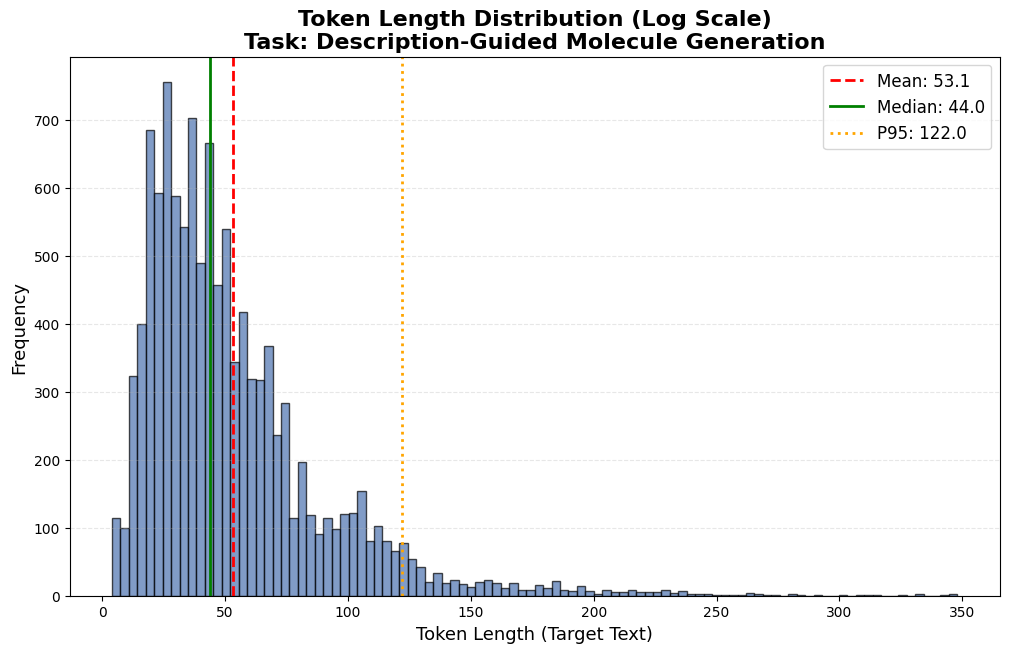

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk
from transformers import AutoTokenizer
import multiprocessing as mp

# =============================================================================
# [설정] 변수 입력
# =============================================================================
MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct"
NUM_PROC = 64
TARGET_GROUP = "Description-Guided Molecule Generation"

# 분석할 데이터셋 경로
TEST_PATH = "Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415_verified_filtered_512"

# 그래프 저장 경로
PLOT_SAVE_DIR = "Mol-LLM_Custom/dataset/analysis_plots"
PLOT_FILENAME = "whole_distribution_desc_guided_mol_gen.png"

# SELFIES 사전 경로
SELFIES_DICT_PATH = "Mol-LLM_Custom/model/selfies_dict.txt"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# =============================================================================
# [1] Tokenizer & Helper Functions (기존 로직 유지)
# =============================================================================
BOOL = ["<BOOLEAN>", "</BOOLEAN>"]
FLOAT = ["<FLOAT>", "</FLOAT>"]
DESCRIPTION = ["<DESCRIPTION>", "</DESCRIPTION>"]
SELFIES = ["<SELFIES>", "</SELFIES>"]
MOL_2D = ["<GRAPH>", "</GRAPH>"]
MOL_3D = ["<3D_CONFORMER>", "</3D_CONFORMER>"]
MOL_EMBEDDING = ["<mol>"]
NUMBER = [f"<|{i}|>" for i in range(10)] + ["<|+|>", "<|-|>", "<|.|>"]
INSTRUCTION = ["<INSTRUCTION>", "</INSTRUCTION>"]
REACTION_DIRECTION = ["|>>|"]
IUPAC = ["<IUPAC>", "</IUPAC>"]
MOLFORMULA = ["<MOLFORMULA>", "</MOLFORMULA>"]

CUSTOM_SPECIAL_TOKENS = (
    BOOL + FLOAT + DESCRIPTION + SELFIES + MOL_2D + MOL_3D + 
    MOL_EMBEDDING + NUMBER + INSTRUCTION + REACTION_DIRECTION + 
    IUPAC + MOLFORMULA
)

global_tokenizer = None

def load_selfies_tokens(path):
    if not os.path.exists(path): return []
    with open(path, 'r') as f:
        tokens = f.read().splitlines()
    return [t.strip() for t in tokens if t.strip()]

def init_worker():
    global global_tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        tokens_to_add = list(set(CUSTOM_SPECIAL_TOKENS))
        tokens_to_add.extend(load_selfies_tokens(SELFIES_DICT_PATH))
        
        existing_vocab = set(tokenizer.get_vocab().keys())
        final_tokens = [t for t in set(tokens_to_add) if t not in existing_vocab]
        
        if final_tokens:
            tokenizer.add_tokens(final_tokens)
        global_tokenizer = tokenizer
    except Exception:
        pass

def get_task_group(task_name):
    if not isinstance(task_name, str): return "Others"
    t = task_name.lower()
    if "generation" in t or "text2mol" in t: return "Description-Guided Molecule Generation"
    return "Others"

def compute_metadata(batch):
    """길이 및 그룹 계산"""
    if global_tokenizer is None: init_worker()
    
    # Target Text에 대해서만 길이 계산
    t_enc = global_tokenizer(batch['target_text'], add_special_tokens=True, truncation=False)
    lengths = [len(ids) for ids in t_enc['input_ids']]
    groups = [get_task_group(t) for t in batch['task']]
    
    return {
        "target_length": lengths,
        "task_group": groups
    }

# =============================================================================
# [Main Process] - Visualization Only
# =============================================================================
def main():
    print(f"=== Analyzing Whole Dataset Distribution for '{TARGET_GROUP}' ===")
    
    os.makedirs(PLOT_SAVE_DIR, exist_ok=True)
    init_worker() # 메인 프로세스에서도 토크나이저 로드 확인

    if not os.path.exists(TEST_PATH):
        print(f"Error: Test path not found: {TEST_PATH}")
        return

    # 1. 데이터 로드
    print(f"\nLoading Dataset...")
    ds = load_from_disk(TEST_PATH)
    
    # 2. 메타데이터(길이) 계산
    # num_proc을 사용하여 병렬 처리
    print("Computing token lengths...")
    ds_with_meta = ds.map(
        compute_metadata,
        batched=True,
        num_proc=NUM_PROC,
        desc="Tokenizing & Computing Metadata"
    )

    # 3. Task Group 필터링 (Threshold 조건 없이 전체)
    print(f"Filtering for task group: {TARGET_GROUP}...")
    filtered_ds = ds_with_meta.filter(
        lambda x: x['task_group'] == TARGET_GROUP,
        num_proc=NUM_PROC,
        desc="Filtering Task Group"
    )

    if len(filtered_ds) == 0:
        print("No data found for the target task group.")
        return

    # 4. 길이 데이터 추출 (메모리 효율을 위해 numpy 변환)
    lengths = np.array(filtered_ds['target_length'])
    
    # 통계 계산
    mean_len = np.mean(lengths)
    median_len = np.median(lengths)
    max_len = np.max(lengths)
    p95 = np.percentile(lengths, 95)
    p99 = np.percentile(lengths, 99)

    print("-" * 50)
    print(f"Total Samples: {len(lengths):,}")
    print(f"Mean:   {mean_len:.2f}")
    print(f"Median: {median_len:.2f}")
    print(f"Max:    {max_len}")
    print(f"95th Percentile: {p95:.2f}")
    print(f"99th Percentile: {p99:.2f}")
    print("-" * 50)

    # 5. 히스토그램 그리기
    print("Generating Histogram...")
    plt.figure(figsize=(12, 7))
    
    # 데이터 분포를 잘 보여주기 위해 bin 개수 자동 조정 혹은 고정
    counts, bins, _ = plt.hist(lengths, bins=100, color='#4C72B0', edgecolor='black', alpha=0.7)
    
    plt.title(f'Token Length Distribution\nTask: {TARGET_GROUP}', fontsize=16, fontweight='bold')
    plt.xlabel('Token Length (Target Text)', fontsize=13)
    plt.ylabel('Frequency', fontsize=13)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # 통계선 추가
    plt.axvline(mean_len, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_len:.1f}')
    plt.axvline(median_len, color='green', linestyle='-', linewidth=2, label=f'Median: {median_len:.1f}')
    plt.axvline(p95, color='orange', linestyle=':', linewidth=2, label=f'P95: {p95:.1f}')
    
    plt.legend(fontsize=12)
    
    # 저장
    save_path = os.path.join(PLOT_SAVE_DIR, PLOT_FILENAME)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nHistogram saved to: {save_path}")
    
    # (옵션) 로그 스케일도 함께 저장 (긴 꼬리 데이터 확인용)
    # plt.yscale('log')
    plt.title(f'Token Length Distribution (Log Scale)\nTask: {TARGET_GROUP}', fontsize=16, fontweight='bold')
    save_log_path = save_path.replace(".png", "_log.png")
    # plt.savefig(save_log_path, dpi=300, bbox_inches='tight')
    print(f"Log-scale histogram saved to: {save_log_path}")

    print("\nDone.")

if __name__ == "__main__":
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass
    main()